<a href="https://colab.research.google.com/github/mehrshad-sdtn/BSc-Thesis-Project/blob/master/notebooks/vae_data_synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import glob
import pathlib
import PIL, PIL.Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import layers
from keras import backend as K
import logging

In [ ]:
base_dir = '/content/drive/MyDrive'
data_dir = os.path.join(base_dir, 'BSc_Project', 'out')
dataset_path = os.path.join(data_dir, 'A')

In [ ]:
models_path = os.path.join(base_dir, 'BSc_Project', 'models')

**Loading the image dataset**

In [ ]:
height = 224
width = 224

def image_read(image_dir):
  src = cv2.imread(image_dir)
  src_rgb = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
  image = cv2.resize(src_rgb, (width, height))
  image = image.astype('float32') / 255.
  return image



def images_from_directory(dataset_path, cat):
  image_list = []
  images_path = os.path.join(dataset_path, cat)
  images_names = [os.path.join(images_path, name) for name in os.listdir(images_path)]
  for image_dir in images_names:
    image = image_read(image_dir)
    image_list.append(image)
  return image_list


norm_list = images_from_directory(dataset_path, 'norm')
sch_list  = images_from_directory(dataset_path, 'sch')


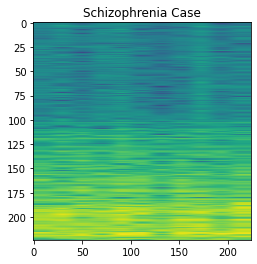

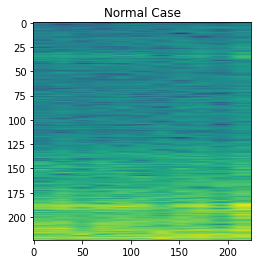

In [ ]:
import matplotlib.pyplot as plt

i = 2
plt.title("Schizophrenia Case")
plt.imshow(sch_list[i])
plt.show()
plt.title("Normal Case")
plt.imshow(norm_list[i])
plt.show()

In [ ]:
print("size of normal image dataset:", len(norm_list))
print("size of schizophrenic dataset:", len(sch_list))
print(norm_list[0].shape)

size of normal image dataset: 444
size of schizophrenic dataset: 504
(224, 224, 3)


In [ ]:
X_norm = np.array(norm_list)
X_sch = np.array(sch_list)

In [ ]:
X_norm.shape, X_sch.shape

((444, 224, 224, 3), (504, 224, 224, 3))

In [ ]:
def train_validation_split(X, ratio=0.2):
  length = int(ratio * X.shape[0])
  return X[length:], X[:length]


X_norm_train, X_norm_valid = train_validation_split(X_norm)
X_sch_train, X_sch_valid = train_validation_split(X_sch)

X_norm_train.shape, X_norm_valid.shape, X_sch_train.shape, X_sch_valid.shape

((356, 224, 224, 3), (88, 224, 224, 3), (404, 224, 224, 3), (100, 224, 224, 3))

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows), dpi=190)
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")

**building and training the VAE**

In [ ]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

latent_dim = 512


def encoder(inputs):
  # (224, 224, 3)

  x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs) 
  # (112, 112, 32)

  x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
  # (56, 56, 64)

  x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
  # (28, 28, 128)

  x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
  # (14, 14, 256)

  x = layers.Conv2D(512, 3, activation="relu", strides=2, padding="same")(x)
  # (7, 7, 512)

  x = layers.Flatten()(x)
  x = layers.Dense(1024, activation="relu")(x)
  x = layers.Dense(1024, activation="relu")(x)

  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  v_encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
  v_encoder.summary()
  return v_encoder, z_log_var, z_mean


def decoder():
  latent_inputs = keras.Input(shape=(latent_dim,))

  x = layers.Dense(1024, activation="relu")(latent_inputs)
  x = layers.Dense(1024, activation="relu")(x)
  x = layers.Dense(7*7*512, activation="relu")(x)
  x = layers.Reshape((7, 7, 512))(x)

  x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
  # (14, 14, 256)

  x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
  # (28, 28, 128)

  x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
  # (56, 56, 64)

  x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
  # (112, 112, 32)

  decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid",  strides=2, padding="same")(x)
  v_decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
  v_decoder.summary()
  return v_decoder



####**Training For Normal Data Synthesis**

In [ ]:
inputs = keras.layers.Input(shape=(224, 224, 3))
norm_encoder, norm_codings_log_var, norm_codings_mean = encoder(inputs)
norm_decoder = decoder()
_, _, norm_codings = norm_encoder(inputs)
norm_reconstructions = norm_decoder(norm_codings)
norm_vae = keras.models.Model(inputs=[inputs], outputs=[norm_reconstructions])

latent_loss = -0.5 * K.sum(1 + norm_codings_log_var - K.exp(norm_codings_log_var) - K.square(norm_codings_mean), axis=-1)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 112, 112, 32  896         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 56, 56, 64)   18496       ['conv2d_20[0][0]']              
                                                                                            

In [ ]:
norm_vae.add_loss(K.mean(latent_loss) / (224*224*3))
rms_prop = keras.optimizers.Adam(learning_rate = 0.00008)
norm_vae.compile(loss="binary_crossentropy", optimizer= rms_prop, metrics=[rounded_accuracy])
history = norm_vae.fit(X_norm_train, X_norm_train, epochs=1000, batch_size=32, validation_data=(X_norm_valid, X_norm_valid))

Epoch 1/1000
12/12 [==============================] - 4s 165ms/step - loss: 0.6930 - rounded_accuracy: 0.6042 - val_loss: 0.6928 - val_rounded_accuracy: 0.6813
Epoch 2/1000
12/12 [==============================] - 2s 128ms/step - loss: 0.6926 - rounded_accuracy: 0.6848 - val_loss: 0.6923 - val_rounded_accuracy: 0.6924
Epoch 3/1000
12/12 [==============================] - 2s 127ms/step - loss: 0.6918 - rounded_accuracy: 0.6823 - val_loss: 0.6905 - val_rounded_accuracy: 0.6792
Epoch 4/1000
12/12 [==============================] - 2s 127ms/step - loss: 0.6865 - rounded_accuracy: 0.6713 - val_loss: 0.6731 - val_rounded_accuracy: 0.6767
Epoch 5/1000
12/12 [==============================] - 2s 128ms/step - loss: 0.6664 - rounded_accuracy: 0.6796 - val_loss: 0.6570 - val_rounded_accuracy: 0.6957
Epoch 6/1000
12/12 [==============================] - 2s 128ms/step - loss: 0.6523 - rounded_accuracy: 0.7037 - val_loss: 0.6440 - val_rounded_accuracy: 0.7286
Epoch 7/1000
12/12 [====================

In [ ]:
history = norm_vae.fit(X_norm_train, X_norm_train, epochs=1000, batch_size=32, validation_data=(X_norm_valid, X_norm_valid))

Epoch 1/1000
12/12 [==============================] - 2s 140ms/step - loss: 0.5944 - rounded_accuracy: 0.9261 - val_loss: 0.5966 - val_rounded_accuracy: 0.9170
Epoch 2/1000
12/12 [==============================] - 2s 127ms/step - loss: 0.5944 - rounded_accuracy: 0.9258 - val_loss: 0.5966 - val_rounded_accuracy: 0.9168
Epoch 3/1000
12/12 [==============================] - 2s 129ms/step - loss: 0.5944 - rounded_accuracy: 0.9263 - val_loss: 0.5966 - val_rounded_accuracy: 0.9173
Epoch 4/1000
12/12 [==============================] - 2s 129ms/step - loss: 0.5944 - rounded_accuracy: 0.9262 - val_loss: 0.5966 - val_rounded_accuracy: 0.9168
Epoch 5/1000
12/12 [==============================] - 2s 129ms/step - loss: 0.5944 - rounded_accuracy: 0.9261 - val_loss: 0.5966 - val_rounded_accuracy: 0.9168
Epoch 6/1000
12/12 [==============================] - 2s 129ms/step - loss: 0.5944 - rounded_accuracy: 0.9261 - val_loss: 0.5965 - val_rounded_accuracy: 0.9166
Epoch 7/1000
12/12 [====================

In [ ]:
history = norm_vae.fit(X_norm_train, X_norm_train, epochs=1000, batch_size=32, validation_data=(X_norm_valid, X_norm_valid))

Epoch 1/1000
12/12 [==============================] - 2s 135ms/step - loss: 0.5896 - rounded_accuracy: 0.9715 - val_loss: 0.5989 - val_rounded_accuracy: 0.9030
Epoch 2/1000
12/12 [==============================] - 2s 127ms/step - loss: 0.5896 - rounded_accuracy: 0.9712 - val_loss: 0.5988 - val_rounded_accuracy: 0.9026
Epoch 3/1000
12/12 [==============================] - 2s 128ms/step - loss: 0.5896 - rounded_accuracy: 0.9709 - val_loss: 0.5989 - val_rounded_accuracy: 0.9028
Epoch 4/1000
12/12 [==============================] - 2s 128ms/step - loss: 0.5896 - rounded_accuracy: 0.9711 - val_loss: 0.5988 - val_rounded_accuracy: 0.9033
Epoch 5/1000
12/12 [==============================] - 2s 127ms/step - loss: 0.5896 - rounded_accuracy: 0.9717 - val_loss: 0.5989 - val_rounded_accuracy: 0.9035
Epoch 6/1000
12/12 [==============================] - 2s 127ms/step - loss: 0.5896 - rounded_accuracy: 0.9715 - val_loss: 0.5988 - val_rounded_accuracy: 0.9039
Epoch 7/1000
12/12 [====================

In [ ]:
history = norm_vae.fit(X_norm_train, X_norm_train, epochs=1000, batch_size=32, validation_data=(X_norm_valid, X_norm_valid))

Epoch 1/1000
12/12 [==============================] - 2s 138ms/step - loss: 0.5889 - rounded_accuracy: 0.9848 - val_loss: 0.5986 - val_rounded_accuracy: 0.9042
Epoch 2/1000
12/12 [==============================] - 2s 127ms/step - loss: 0.5889 - rounded_accuracy: 0.9846 - val_loss: 0.5985 - val_rounded_accuracy: 0.9046
Epoch 3/1000
12/12 [==============================] - 2s 128ms/step - loss: 0.5889 - rounded_accuracy: 0.9846 - val_loss: 0.5986 - val_rounded_accuracy: 0.9042
Epoch 4/1000
12/12 [==============================] - 2s 129ms/step - loss: 0.5889 - rounded_accuracy: 0.9849 - val_loss: 0.5985 - val_rounded_accuracy: 0.9043
Epoch 5/1000
12/12 [==============================] - 2s 129ms/step - loss: 0.5889 - rounded_accuracy: 0.9850 - val_loss: 0.5986 - val_rounded_accuracy: 0.9039
Epoch 6/1000
12/12 [==============================] - 2s 130ms/step - loss: 0.5889 - rounded_accuracy: 0.9851 - val_loss: 0.5985 - val_rounded_accuracy: 0.9044
Epoch 7/1000
12/12 [====================

In [ ]:
history = norm_vae.fit(X_norm_train, X_norm_train, epochs=1000, batch_size=32, validation_data=(X_norm_valid, X_norm_valid))

Epoch 1/1000
12/12 [==============================] - 2s 134ms/step - loss: 0.5887 - rounded_accuracy: 0.9882 - val_loss: 0.5983 - val_rounded_accuracy: 0.9054
Epoch 2/1000
12/12 [==============================] - 2s 128ms/step - loss: 0.5887 - rounded_accuracy: 0.9882 - val_loss: 0.5983 - val_rounded_accuracy: 0.9055
Epoch 3/1000
12/12 [==============================] - 2s 128ms/step - loss: 0.5887 - rounded_accuracy: 0.9883 - val_loss: 0.5983 - val_rounded_accuracy: 0.9057
Epoch 4/1000
12/12 [==============================] - 2s 129ms/step - loss: 0.5887 - rounded_accuracy: 0.9882 - val_loss: 0.5982 - val_rounded_accuracy: 0.9054
Epoch 5/1000
12/12 [==============================] - 2s 129ms/step - loss: 0.5887 - rounded_accuracy: 0.9882 - val_loss: 0.5983 - val_rounded_accuracy: 0.9054
Epoch 6/1000
12/12 [==============================] - 2s 129ms/step - loss: 0.5887 - rounded_accuracy: 0.9882 - val_loss: 0.5983 - val_rounded_accuracy: 0.9059
Epoch 7/1000
12/12 [====================

In [ ]:
history = norm_vae.fit(X_norm_train, X_norm_train, epochs=500, batch_size=32, validation_data=(X_norm_valid, X_norm_valid))

Epoch 1/500
12/12 [==============================] - 2s 138ms/step - loss: 0.5887 - rounded_accuracy: 0.9895 - val_loss: 0.5981 - val_rounded_accuracy: 0.9065
Epoch 2/500
12/12 [==============================] - 2s 130ms/step - loss: 0.5887 - rounded_accuracy: 0.9896 - val_loss: 0.5982 - val_rounded_accuracy: 0.9063
Epoch 3/500
12/12 [==============================] - 2s 128ms/step - loss: 0.5887 - rounded_accuracy: 0.9896 - val_loss: 0.5981 - val_rounded_accuracy: 0.9066
Epoch 4/500
12/12 [==============================] - 2s 128ms/step - loss: 0.5887 - rounded_accuracy: 0.9896 - val_loss: 0.5981 - val_rounded_accuracy: 0.9066
Epoch 5/500
12/12 [==============================] - 2s 130ms/step - loss: 0.5887 - rounded_accuracy: 0.9897 - val_loss: 0.5982 - val_rounded_accuracy: 0.9064
Epoch 6/500
12/12 [==============================] - 2s 129ms/step - loss: 0.5887 - rounded_accuracy: 0.9897 - val_loss: 0.5982 - val_rounded_accuracy: 0.9061
Epoch 7/500
12/12 [===========================

####**Training For Schizophrenia Data Synthesis**

In [ ]:
inputs = keras.layers.Input(shape=(224, 224, 3))
sch_encoder, sch_codings_log_var, sch_codings_mean = encoder(inputs)
sch_decoder = decoder()
_, _, sch_codings = sch_encoder(inputs)
sch_reconstructions = sch_decoder(sch_codings)
sch_vae = keras.models.Model(inputs=[inputs], outputs=[sch_reconstructions])

sch_latent_loss = -0.5 * K.sum(1 + sch_codings_log_var - K.exp(sch_codings_log_var) - K.square(sch_codings_mean), axis=-1)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_25 (Conv2D)             (None, 112, 112, 32  896         ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_26 (Conv2D)             (None, 56, 56, 64)   18496       ['conv2d_25[0][0]']              
                                                                                            

In [69]:
sch_vae.add_loss(K.mean(sch_latent_loss) / (224*224*3))
rms_prop = keras.optimizers.Adam(learning_rate = 0.00008)
sch_vae.compile(loss="binary_crossentropy", optimizer= rms_prop, metrics=[rounded_accuracy]) 
history = sch_vae.fit(X_sch_train, X_sch_train, epochs=4000, batch_size=32, validation_data=(X_sch_valid, X_sch_valid))

Streaming output truncated to the last 5000 lines.
13/13 [==============================] - 2s 139ms/step - loss: 0.5903 - rounded_accuracy: 0.9626 - val_loss: 0.5970 - val_rounded_accuracy: 0.8987
Epoch 1469/4000
13/13 [==============================] - 2s 139ms/step - loss: 0.5903 - rounded_accuracy: 0.9626 - val_loss: 0.5969 - val_rounded_accuracy: 0.8991
Epoch 1470/4000
13/13 [==============================] - 2s 138ms/step - loss: 0.5903 - rounded_accuracy: 0.9627 - val_loss: 0.5969 - val_rounded_accuracy: 0.8987
Epoch 1471/4000
13/13 [==============================] - 2s 142ms/step - loss: 0.5903 - rounded_accuracy: 0.9627 - val_loss: 0.5970 - val_rounded_accuracy: 0.8992
Epoch 1472/4000
13/13 [==============================] - 2s 140ms/step - loss: 0.5903 - rounded_accuracy: 0.9627 - val_loss: 0.5969 - val_rounded_accuracy: 0.8987
Epoch 1473/4000
13/13 [==============================] - 2s 138ms/step - loss: 0.5903 - rounded_accuracy: 0.9627 - val_loss: 0.5969 - val_rounded_accu

In [73]:
history = sch_vae.fit(X_sch_train, X_sch_train, epochs=1000, batch_size=32, validation_data=(X_sch_valid, X_sch_valid))

Epoch 1/1000
13/13 [==============================] - 2s 142ms/step - loss: 0.5890 - rounded_accuracy: 0.9890 - val_loss: 0.5960 - val_rounded_accuracy: 0.9013
Epoch 2/1000
13/13 [==============================] - 2s 134ms/step - loss: 0.5890 - rounded_accuracy: 0.9888 - val_loss: 0.5960 - val_rounded_accuracy: 0.9015
Epoch 3/1000
13/13 [==============================] - 2s 135ms/step - loss: 0.5890 - rounded_accuracy: 0.9890 - val_loss: 0.5961 - val_rounded_accuracy: 0.9007
Epoch 4/1000
13/13 [==============================] - 2s 134ms/step - loss: 0.5890 - rounded_accuracy: 0.9888 - val_loss: 0.5961 - val_rounded_accuracy: 0.9012
Epoch 5/1000
13/13 [==============================] - 2s 135ms/step - loss: 0.5890 - rounded_accuracy: 0.9889 - val_loss: 0.5960 - val_rounded_accuracy: 0.9012
Epoch 6/1000
13/13 [==============================] - 2s 137ms/step - loss: 0.5890 - rounded_accuracy: 0.9891 - val_loss: 0.5960 - val_rounded_accuracy: 0.9010
Epoch 7/1000
13/13 [====================

In [ ]:
def save_autoencoder(enc, dec):
  """
  enc & dec are dictionaries containing 'model' and 'name'
  """
  enc['model'].save(os.path.join(models_path, enc['name']))
  dec['model'].save(os.path.join(models_path, dec['name']))


def load_autoencoder(names):
  """
  names is a dictionary containing 'decoder' and 'encoder' names
  """
  encoder = keras.models.load_model(os.path.join(models_path, names['encoder']), custom_objects={'Sampling':Sampling}) 
  decoder = keras.models.load_model(os.path.join(models_path, names['decoder']))
  return encoder, decoder 

In [ ]:
save_autoencoder(enc={'model': norm_encoder, 'name': 'norm_encoder.h5'}, dec={'model': norm_decoder, 'name': 'norm_decoder.h5'})

In [75]:
save_autoencoder(enc={'model': sch_encoder, 'name': 'sch_encoder.h5'}, dec={'model': sch_decoder, 'name': 'sch_decoder.h5'})

In [ ]:
norm_encoder_model, norm_decoder_model = load_autoencoder({'encoder': 'norm_encoder.h5', 'decoder': 'norm_decoder.h5'})

In [76]:
sch_encoder_model, sch_decoder_model = load_autoencoder({'encoder': 'sch_encoder.h5', 'decoder': 'sch_decoder.h5'})

VAE generated norm images:


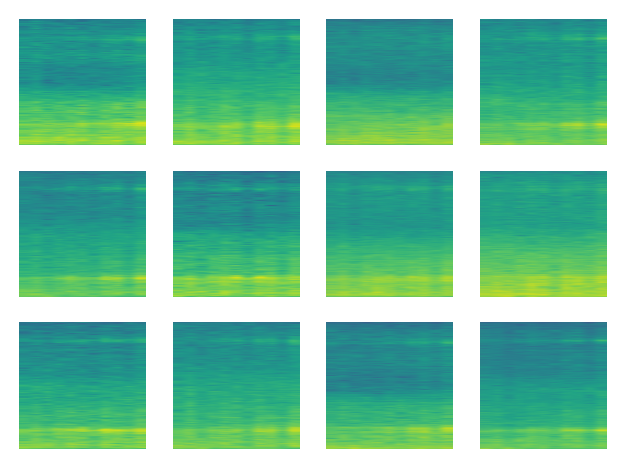


Original norm images:


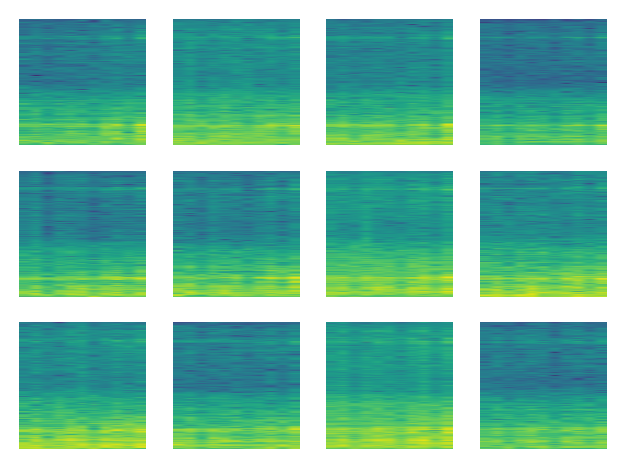

In [ ]:
#tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, latent_dim])
images = norm_decoder(codings).numpy()

print('VAE generated norm images:')
plot_multiple_images(images, 4)
plt.show() 

print('\nOriginal norm images:')
plot_multiple_images(X_norm_valid[:12], 4)  
plt.show() 

VAE generated norm images:


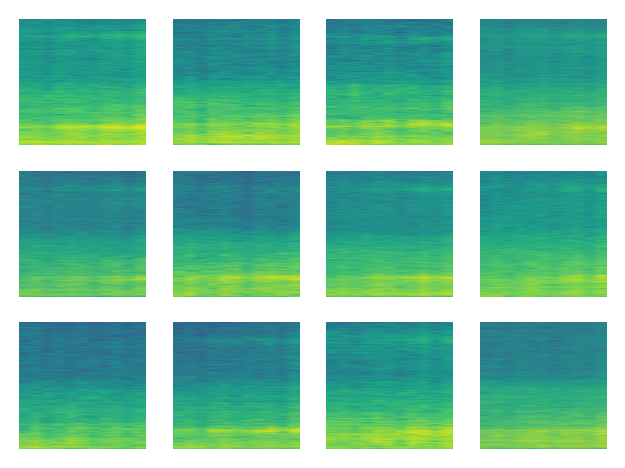


Original norm images:


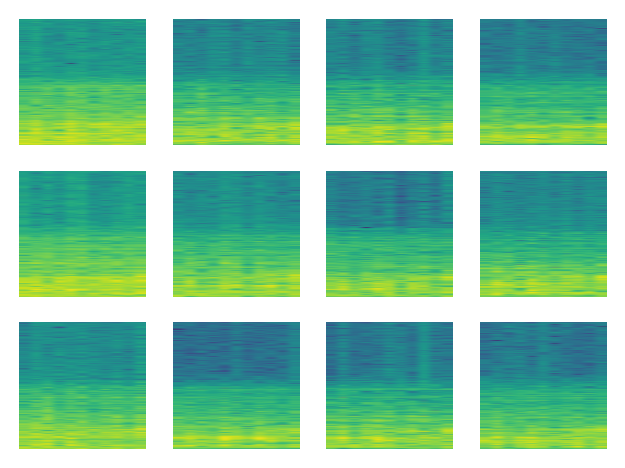

In [77]:
codings = tf.random.normal(shape=[12, latent_dim])
images = sch_decoder_model(codings).numpy()

print('VAE generated sch images:')
plot_multiple_images(images, 4)
plt.show() 

print('\nOriginal sch images:')
plot_multiple_images(X_sch_valid[:12], 4)  
plt.show() 